In [5]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Wine dataset with response in {0, 1, 2}, 13 features and 178 samples
X, y = load_wine(return_X_y=True)

In [11]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size=0.3, random_state=42)

## Case 1: Analytical attack - Max disruption

In [4]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [5]:
def kl_div(mu_n, lam_n, sigma2, x, x_adv):
    sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2
    mu_A = x_adv.T @ mu_n
    sigma2_D = x.T @ torch.inverse(lam_n) @ x + sigma2
    mu_D = x.T @ mu_n
    kl = 0.5 * (torch.log(sigma2_D / sigma2_A) + (sigma2_A + (mu_A - mu_D)**2) / sigma2_D - 1)
    return kl

In [6]:
# kl minimization to find adversarial attacked to a trained model
def kl_minimization(model, x, lr=0.01, n_iter=100, epsilon=.3):
    x_adv_values = []
    kl_values = []
    
    mu_n = model.mu
    lam_n = model.lam
    sigma2 = model.sigma2
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)
    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
        kl.backward()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        kl_values.append(kl.detach().item())

    return x_adv.detach().numpy(), x_adv_values, kl_values 

In [7]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values, kl_values = kl_minimization(model, x)

/tmp/ipykernel_326562/3086203720.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905991019/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  sigma2_A = x_adv.T @ torch.inverse(lam_n) @ x_adv + sigma2


In [62]:
print(x_adv_distr, '\n', X_test[17,:])

[1.0905532  0.202382   0.1517193  0.52731913 0.766045   0.16137284
 0.27361834 0.20018966 0.60258293 0.40303457 0.16233222 0.60249215
 0.45058197 0.17143686] 
 [1.         0.27631579 0.0770751  0.61497326 0.69072165 0.08695652
 0.35172414 0.26160338 0.50943396 0.31230284 0.07849829 0.67479675
 0.53113553 0.2510699 ]


Text(0, 0.5, 'KL Divergence')

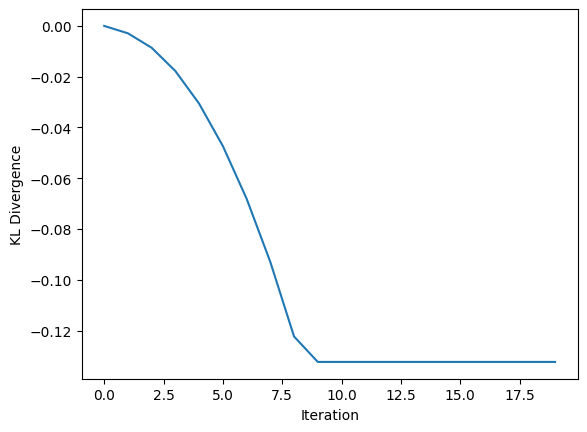

In [8]:
plt.plot(kl_values[:20])
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')

Text(0.5, 0, 'y')

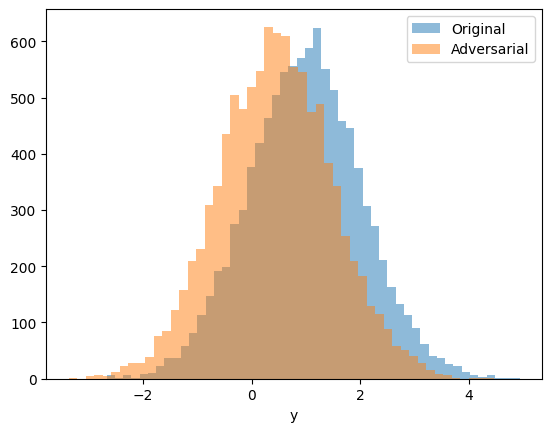

In [9]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')

## Case 2: SGD attack

In [10]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [11]:
# Function to sample gamma from pi(gamma | D)
def sample_gamma(model, M):
    a = model.a
    b = model.b
    mu = model.mu
    lam = model.lam
    sigma2 = torch.distributions.inverse_gamma.InverseGamma(a, b).sample((M,))
    beta = torch.distributions.multivariate_normal.MultivariateNormal(mu, torch.inverse(lam) * sigma2.unsqueeze(1)).sample()
    return [beta, sigma2]

# Function pi(y | x', gamma)
def pi(y, x, gamma):
    return torch.distributions.normal.Normal(x @ gamma[0], gamma[1]).log_prob(y).exp()

# Gradient of pi(y | x', gamma) with respect to x'
# pi(y | x', gamma) is Normal(x' @ beta, sigma2) with beta = gamma[0] and sigma2 = gamma[1]
def grad_pi(y, x, gamma):
    distr = torch.distributions.normal.Normal(x @ gamma[0], gamma[1])
    prob = distr.log_prob(y).exp()
    grad = - (x @ gamma[0] - y) / gamma[1] * prob * gamma[0]
    return grad


In [12]:
# g_{x', M}(y)
def g_x_prime_M(y, x_prime, gamma_samples):
    M = gamma_samples[0].shape[0]
    betas = gamma_samples[0]
    sigmas = gamma_samples[1]
    numerator = sum(grad_pi(y, x_prime, [betas[m], sigmas[m]]) for m in range(M)) / M
    denominator = sum(pi(y, x_prime, [betas[m], sigmas[m]]) for m in range(M)) / M
    return -numerator / denominator

In [13]:
# Define sequence M_l
M_sequence = [2**l for l in range(10)]

In [14]:
# Compute Δg_{x', l}(y)
def delta_g_x_prime_l(y, x_prime, l, model):
    M_l = M_sequence[l]
    M_l_minus_1 = M_sequence[l-1] if l > 0 else 0
    gamma_samples_l = sample_gamma(model, M_l)
    gamma_samples_l_minus_1 = sample_gamma(model, M_l_minus_1) if l > 0 else None

    g_l = g_x_prime_M(y, x_prime, gamma_samples_l)
    g_l_minus_1 = g_x_prime_M(y, x_prime, gamma_samples_l_minus_1) if l > 0 else 0

    return g_l - g_l_minus_1

In [15]:
# Define weights ω_l
tau = 1.0  # Example tau value
omega = [2**(-tau * l) for l in range(len(M_sequence))]
omega = np.array(omega)
omega /= omega.sum()  # Normalize

# Estimate the gradient using MLMC
def mlmc_gradient_estimator(y, x_prime, R, model):
    l_indices = np.random.choice(len(M_sequence), size=R, p=omega)
    estimates = []

    for l in l_indices:
        delta_g = delta_g_x_prime_l(y, x_prime, l, model)
        estimates.append(delta_g / omega[l])
        
    return sum(estimates) / R

# Example usage
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y_test[17], dtype=torch.float32)
R = 100

gradient_estimate = mlmc_gradient_estimator(y, x, R, model)
print(gradient_estimate)

tensor([ 0.9094, -0.2175,  0.2998, -0.0795,  0.4790, -0.0607,  0.2319, -0.6883,
        -0.0286, -0.0172,  0.2043, -0.0805, -0.5077, -0.3658])


In [16]:
# Attack function to use the gradient estimator for maximum disruption
def mlmc_attack(model, x, lr=0.01, n_iter=100, epsilon=.1, R=100):
    x_adv_values = []
    
    x_adv = (x + torch.randn_like(x) * 0.01).clone().detach().requires_grad_(True)  # add some noise to the input so kl is not zero
    optimizer = Adam([x_adv], lr=lr)

    for _ in range(n_iter):
        x_adv.requires_grad = True
        optimizer.zero_grad()
        y = model.sample_predictive_distribution(x_adv, num_samples=1)
        gradient_estimate = mlmc_gradient_estimator(y, x_adv, R, model)
        x_adv.grad = gradient_estimate.squeeze()
        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x, p=2) > epsilon:
                x_adv = x + epsilon * (x_adv - x) / torch.norm(x_adv - x, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())

    return x_adv.detach().numpy(), x_adv_values

In [17]:
# Attack example
x = X_test[17,:].copy()
x = torch.tensor(x, dtype=torch.float32)
x_adv_distr, x_adv_values = mlmc_attack(model, x)

In [235]:
print(x_adv_distr, '\n', X_test[17,:])

[1.023222   0.23885472 0.1020321  0.58682495 0.7265773  0.10624107
 0.3291748  0.25168097 0.48624483 0.32275254 0.10714054 0.64174753
 0.49856982 0.22354369] 
 [1.         0.27631579 0.0770751  0.61497326 0.69072165 0.08695652
 0.35172414 0.26160338 0.50943396 0.31230284 0.07849829 0.67479675
 0.53113553 0.2510699 ]


Text(0.5, 0, 'y')

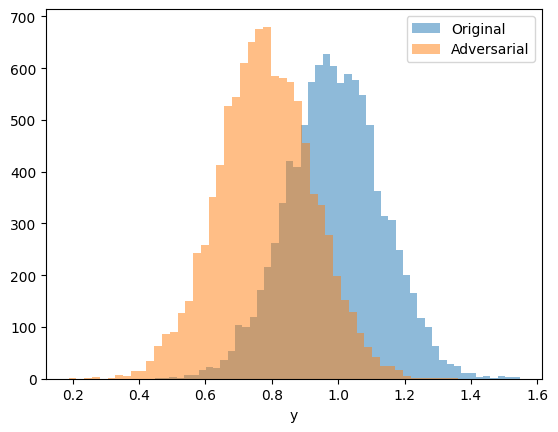

In [18]:
plt.hist(model.sample_predictive_distribution(
    x,
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Original')
plt.hist(model.sample_predictive_distribution(
    torch.tensor(x_adv_distr, dtype=torch.float32),
    num_samples=10000).numpy(), bins=50, alpha=0.5, label='Adversarial')
plt.legend()
plt.xlabel('y')